In [1]:
import matplotlib.ticker as ticker

def decorated_histogram(fig, ax, data, bins=10, **kwargs):
    """
    Plot a histogram with custom decorations.
    
    Parameters:
    - data: array-like, the data to be histogrammed.
    - bins: int or sequence, the bin specification.
    - **kwargs: additional keyword arguments for plt.hist.
    """
    # Enable minor tick labels
    ax.minorticks_on()
    # Plot the histogram
    ax.hist(data, bins=bins, **kwargs)

    
    
    # Customize tick sizes and font sizes
    ax.tick_params(axis='both', which='major', direction='in', top=True, \
                   bottom=True, left=True, right=True, length=7, width=1.5, labelsize=14)
    ax.tick_params(axis='both', which='minor', direction='in', top=True, \
                   bottom=True, left=True, right=True, length=4, width=1, labelsize=10)

    # Enable grid with major and minor ticks
    #ax.grid(True, which='major', linestyle='-', linewidth='0.75', color='black')
    #ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')

    # Set plot boundary thickness
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)

    # Add labels and title if provided
    if 'xlabel' in kwargs:
        ax.set_xlabel(kwargs['xlabel'])
    if 'ylabel' in kwargs:
        ax.set_ylabel(kwargs['ylabel'])
    if 'title' in kwargs:
        ax.set_title(kwargs['title'])
    return ax

In [2]:
from scipy.stats import gaussian_kde

def get_kde_density_and_levels(x, y, grid_x, grid_y, mass_levels=[0.05, 0.25, 0.5, 0.75, 0.95]):
    """
    Compute KDE over a grid and return levels enclosing desired mass_percentiles.
    """
    # Stack and run KDE
    values = np.vstack([x, y])
    kde = gaussian_kde(values)
    positions = np.vstack([grid_x.ravel(), grid_y.ravel()])
    density = kde(positions).reshape(grid_x.shape)

    # Compute density thresholds for cumulative mass levels
    sorted_density = np.sort(density.ravel())[::-1]
    cumsum = np.cumsum(sorted_density)
    cumsum /= cumsum[-1]  # Normalize to 1

    levels = []
    for frac in mass_levels:
        idx = np.searchsorted(cumsum, frac)
        levels.append(sorted_density[idx])
    return density, sorted(levels)

In [3]:
qso_tt = Table.read('../data/CIV-Absorbers-parent-QSO-dr1-v1.0.fits', hdu="METADATA")

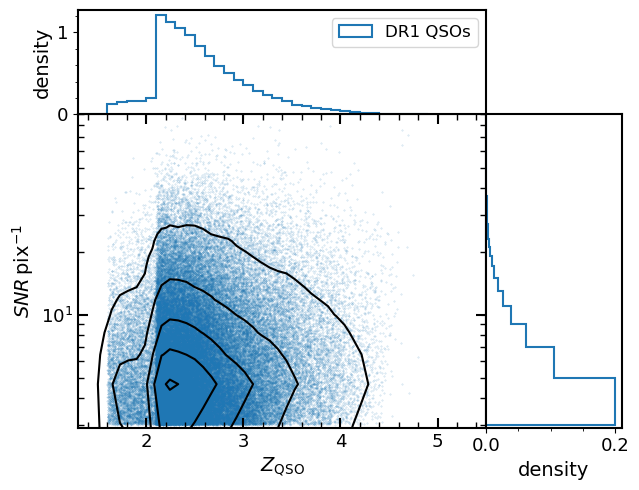

In [4]:
fig = plt.figure(figsize=(6.5,5))
#ax = fig.add_subplot(111)
xd, yd = qso_tt["Z_QSO"].data, qso_tt["MEANSNR"].data
gs = fig.add_gridspec(4, 4, wspace=0.0, hspace=0.0)

# Main scatter density plot
ax_main = fig.add_subplot(gs[1:, :-1])  # Bottom-left (excluding top and right)
ax_main.minorticks_on()
# Customize tick sizes and font sizes
ax_main.tick_params(axis='both', which='major', direction='in', top=True, \
                    bottom=True, left=True, right=True, length=7, width=1.5, labelsize=13)
ax_main.tick_params(axis='both', which='minor', direction='in', top=True, \
                    bottom=True, left=True, right=True, length=4, width=1, labelsize=10)

ax_xhist = fig.add_subplot(gs[0, :-1], sharex=ax_main)  # Top (x-axis histogram)
ax_yhist = fig.add_subplot(gs[1:, -1], sharey=ax_main)  # Right (y-axis histogram)
ax_xhist.minorticks_on()
ax_yhist.minorticks_on()

x1 = xd.byteswap().newbyteorder()
y1 = yd.byteswap().newbyteorder()

# Create grid
xgrid = np.linspace(1.3, 5.5, 50)
ygrid = np.linspace(2.9, 90, 50)
X, Y = np.meshgrid(xgrid, ygrid)

# Compute KDE and levels for enclosed mass
Z, contour_levels = get_kde_density_and_levels(x1, y1, X, Y)

Z[Z <1e-6] = np.nan
cs = ax_main.contour(X, Y, Z, levels=contour_levels, colors='k', linewidths=1.5, zorder=2)

# 2D histogram density plot with white background for empty bins
ax_main.scatter(xd, yd, s=0.1, alpha=0.3, marker='o', rasterized=True)
#hb = ax_main.hist2d(xd, yd, bins=100, cmap="Blues", density=True, cmin=0)
#ax_main.set_facecolor('white')  # Set background to white
ax_main.set_xlabel("$Z_{\\rm QSO}$", fontsize=14)
ax_main.set_ylabel("$ SNR\, \\rm pix^{-1}$", fontsize=14)

# X-axis histogram (Top)
ax_xhist.hist(xd, bins=np.arange(1.3, 5, 0.1), color='C0', histtype='step', lw=1.5, density=True, label='DR1 QSOs')
ax_xhist.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
ax_xhist.tick_params(axis='y', which='major', labelsize=13)  # Ensure Y-axis labels have the right size
ax_xhist.tick_params(axis='y', which='minor', labelsize=7) 
ax_xhist.set_ylabel('density', fontsize=14)
ax_xhist.legend(prop={'size':12})

# Y-axis histogram (Right)
ax_yhist.hist(yd, bins=np.arange(3, 101, 2), color='C0', histtype='step', lw=1.5, orientation='horizontal', density=True)

ax_yhist.tick_params(axis='y', which='both', left=True, right=False, labelleft=False)
ax_yhist.tick_params(axis='x', which='major', labelsize=13)  # Ensure Y-axis labels have the right size
ax_xhist.tick_params(axis='x', which='minor', labelsize=7) 
ax_yhist.set_xlabel('density', fontsize=14)

# Ensuring the right boundary of the main plot is visible
ax_main.spines['right'].set_visible(True)
ax_main.spines['top'].set_visible(True)

ax_main.set_xlim(1.3, 5.5)
ax_main.set_ylim(2.9, 90)
ax_main.set_yscale('log')


# Add black borders to all subplots
for ax in [ax_main, ax_xhist, ax_yhist]:
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1.5)

# Display the plot
fig.tight_layout()